In [1]:
import pandas as pd
import pandahouse as ph
import matplotlib.pyplot as plt
import seaborn as sns

from fbprophet import Prophet

In [2]:
# импорт данных для анализа
ph_connection = {'host': 'http://23.88.5.173:8123',
                 'user': 'o.karnugaev',
                 'password': 'D9oWLlDSwQb3nIZ'}

q = '''
    select date,
       uniqExact(user_id) as DAU
    from bi.all_coupons as ac
    join bi.users as u on u.user_id = ac.user_id
    where u.geo = 'RU'
    group by date
    '''
    
dau_df = ph.read_clickhouse(query=q, connection=ph_connection)

In [3]:
# подготовка данных
dau_df = dau_df.rename(columns={'date': 'ds',
                       'DAU': 'y'})[:dau_df.shape[0]-1]

<AxesSubplot:xlabel='ds', ylabel='y'>

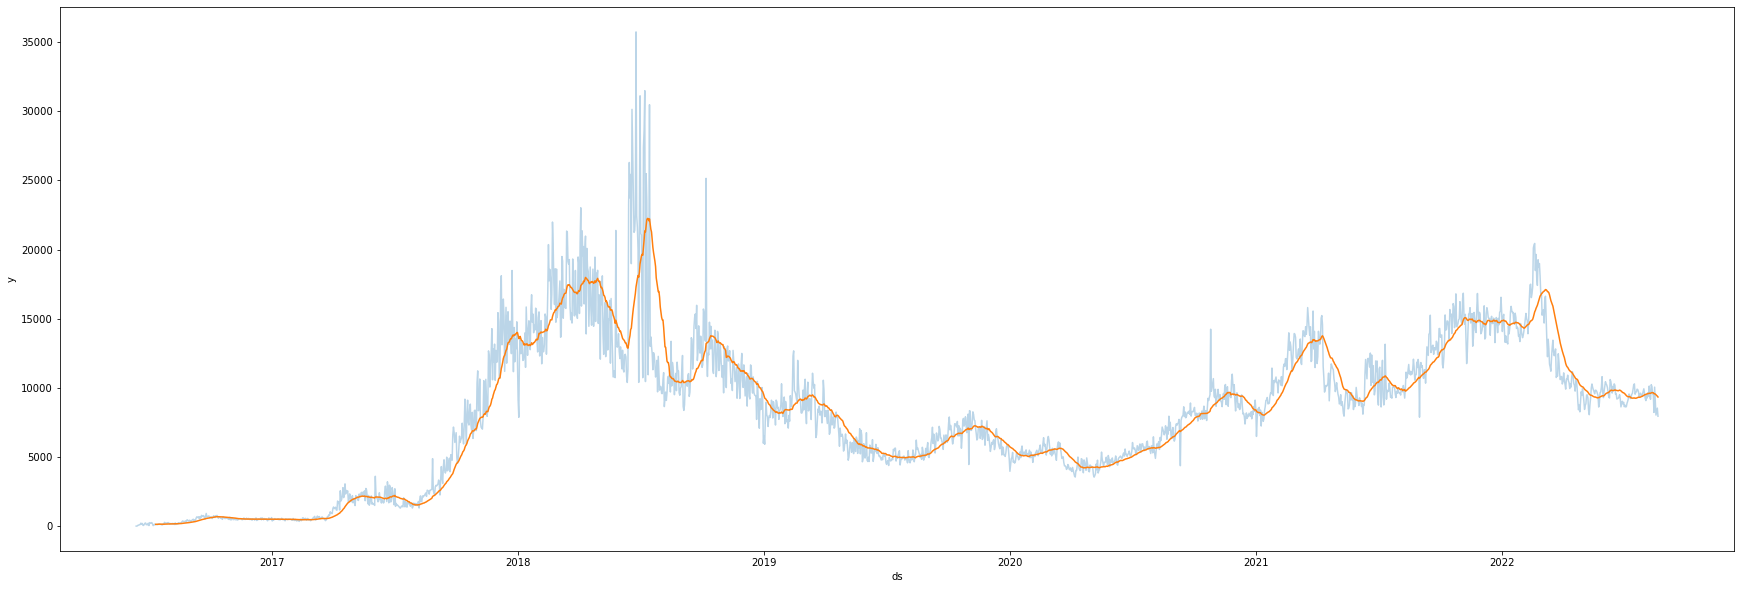

In [4]:
# исторические данные
plt.figure(figsize=(30, 10))

sns.lineplot(data=dau_df, x='ds', y='y', alpha=0.3, legend=True)
sns.lineplot(data=dau_df, x='ds', y=dau_df.y.rolling(30).mean())

In [5]:
# построение модели с учётом сезонности и праздников
pred_model = Prophet(weekly_seasonality=True, yearly_seasonality=True, holidays_prior_scale=4)
Prophet.add_country_holidays(pred_model, country_name='RUS')

In [6]:
perionds = 30
train_df = dau_df[:-perionds]

pred_model.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -29.6648


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5052.3     0.0852439       1350.85           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5132.24    0.00475696       169.716           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       5146.84   0.000111088       139.182   5.534e-07       0.001      305  LS failed, Hessian reset 
     299       5162.66    0.00482631       139.565           1           1      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        5178.5     0.0065456       281.892      0.7738      0.7738      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5195.38    0.00384039        241.55      0.3873           1      6

In [7]:
forecast_data = pred_model.make_future_dataframe(freq='D', periods=perionds)

In [8]:
forecast = pred_model.predict(forecast_data)

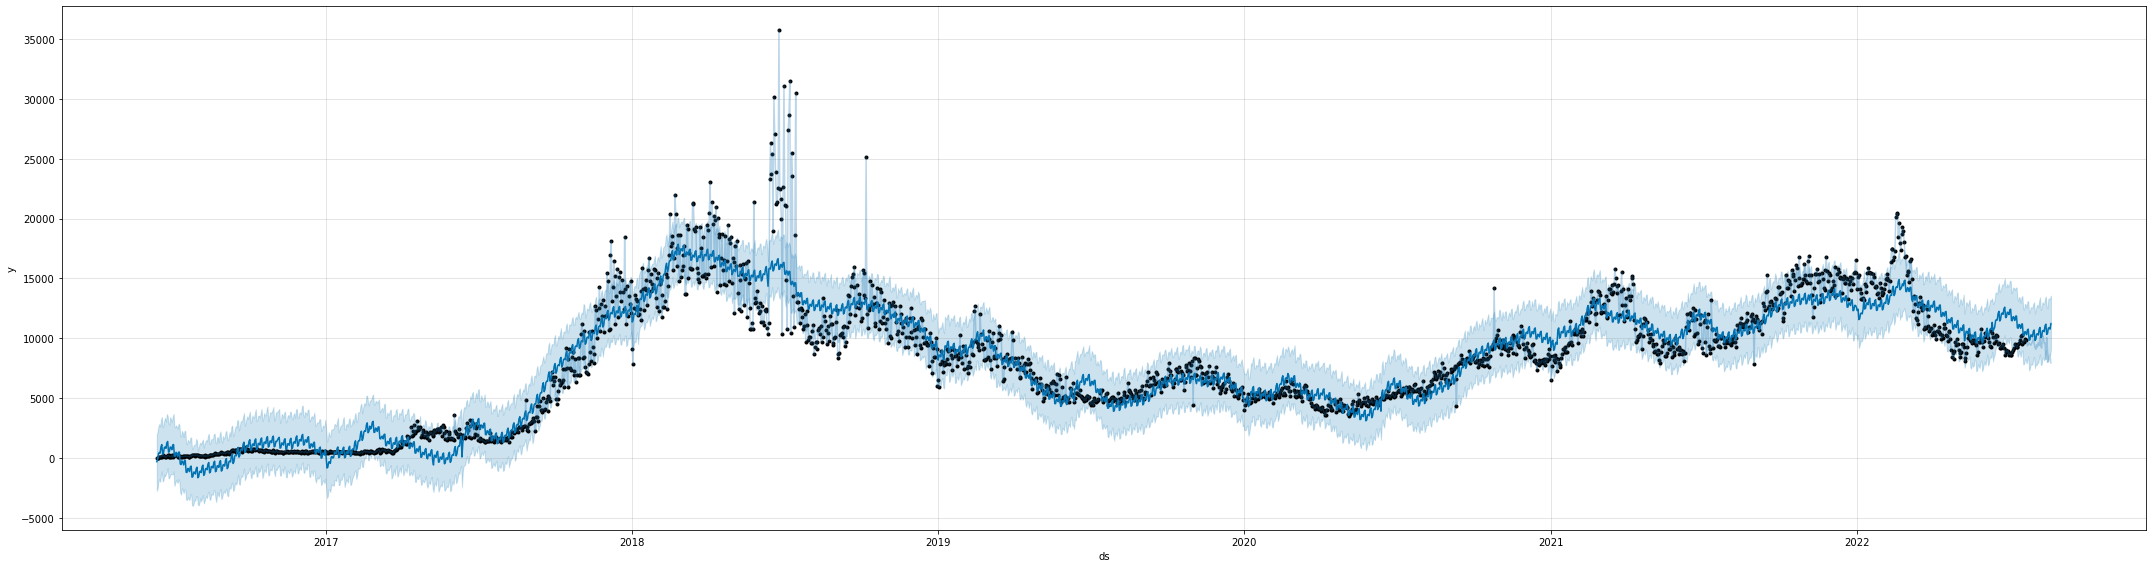

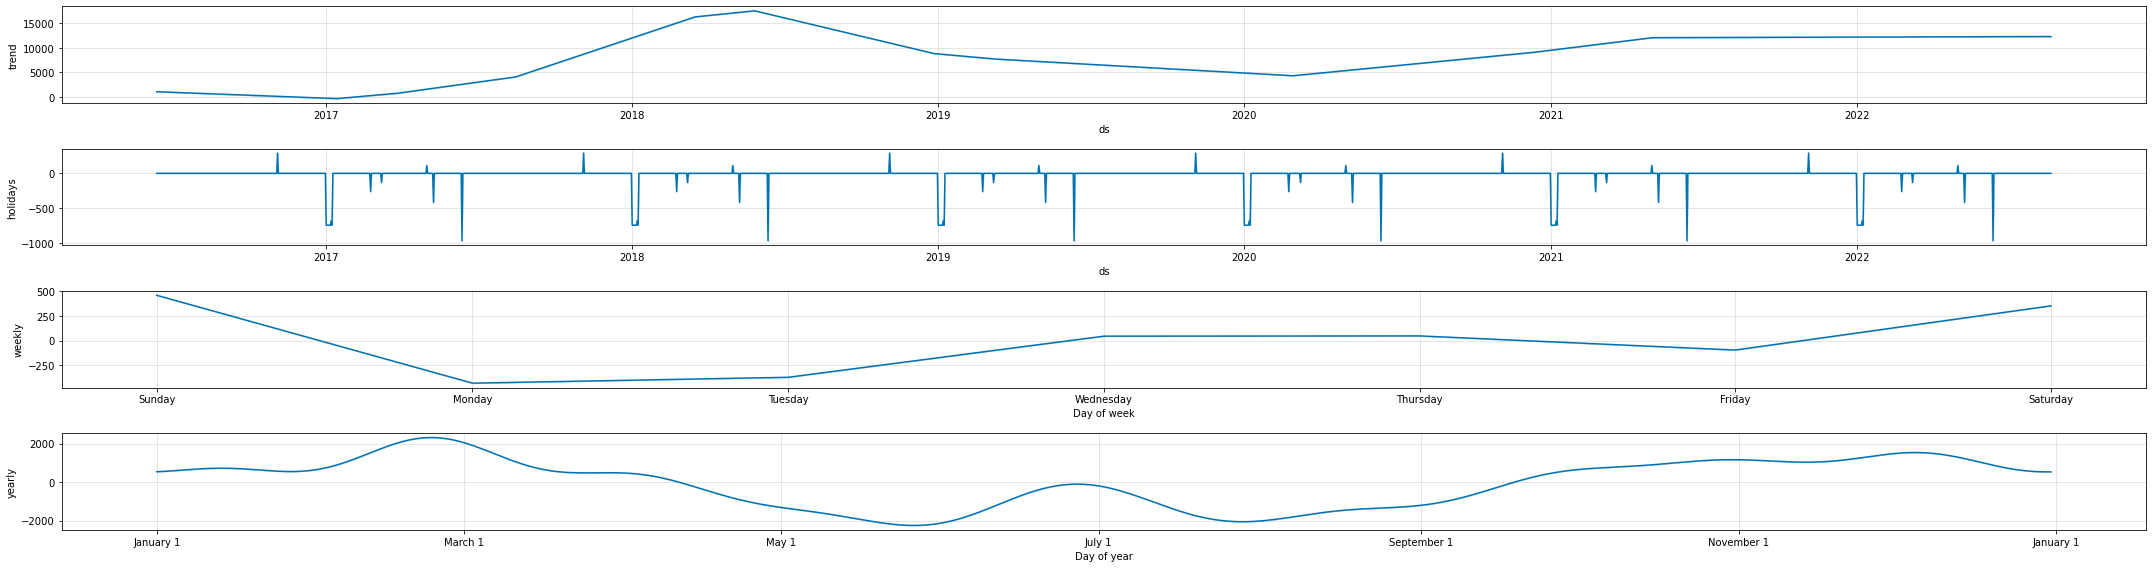

In [9]:
pred_model.plot(forecast, figsize=(30, 8));
sns.lineplot(data=dau_df, x='ds', y='y', alpha=0.3, legend=True)
pred_model.plot_components(forecast, figsize=(30, 8));

In [10]:
predicted_df = forecast[-perionds:][['ds', 'yhat']]
true_data = dau_df[-perionds:]

predicted_df = predicted_df.merge(true_data).astype({'yhat': 'int',
                                     'y': 'int'})

result = predicted_df.eval('e = abs(y - yhat)')\
    .eval('p = e / y')[:perionds-1]

In [12]:
print(f'Средняя абсолютная ошибка = {result.e.mean()}')
print(f'Средняя относительня ошибка = {result.p.mean()}')

Средняя абсолютная ошибка = 1067.5862068965516
Средняя относительня ошибка = 0.11842575384118273
